## Подготовительная работа
* [Installing a Library Permanently in Colab](https://saturncloud.io/blog/how-to-install-a-library-permanently-in-colab/)

In [76]:
## connect google drive
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install virtualenv
!virtualenv /content/drive/MyDrive/vkr/kmu/virtual_env

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 17.4 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 34720ms
  creator CPython3Posix(dest=/content/drive/MyDrive/vkr/kmu/virtual_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: Cython==3.0.10, Jinja2==3.1.3, MarkupSafe==2.1.5, affine==2.4.0, attrs==23.2.0, certifi==2024.2.2, charset_normalizer==3.3.2, click==8.1.7, click_plugins==1.1.1, cligj==0.7.2, contextily==1.6.0, contourpy==1.2.0, cycler==0.12.1, cykhash==2.0.1, fiona==1.9.6, fonttools==4.50.0, geographiclib==2.0, geopandas==0.14.3, geopy==2.4.1, idna==3.6, joblib==1.3.2, kiwisolver==1.4.5, mapclassify==2.6.1, matplotlib==3.8.3, mercantile==1.2.1, networkx==3.2.1, numpy==1.26.4, osmnx==1.9.1, packaging==

In [176]:
import sys


venv_path = "/content/drive/MyDrive/vkr/kmu/virtual_env/lib/python3.10/site-packages"
if venv_path not in sys.path:
  # add the path of the virtual environment site-packages to colab system path
  sys.path.append(venv_path)
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/vkr/kmu/virtual_env/lib/python3.10/site-packages']

## Выгрузка данных из OSM

```bash
!source /content/drive/MyDrive/vkr/kmu/virtual_env/bin/activate; pip install pyrosm contextily mapclassify osmnx
```

In [ ]:
!pip freeze

### Конфигурация

In [177]:
DIR_OSM = '/content/drive/MyDrive/vkr/kmu/src/osm/'
CITY = 'SanktPetersburg'
BBOX = [30.2561753, 59.929385, 30.3637657, 59.9832816]
UTM_ZONE = 32636

config = {
    'dir_osm': DIR_OSM,
    'city': CITY,
    'crs': UTM_ZONE,
    'filters': {
        'buildings': {
            'all': {
                'building': True
            },
            'residential_only': {
                'building': [
                'apartments',
                'residential'
              ]
            }
        },
        'POIs': {
            'shop': [
                'convenience',
                'supermarket',
                'mall',
                'greengrocer'
            ],
            'amenity': [
                'pharmacy',
                'school',
                'kindergarten',
                'clinic'
            ],
            'healthcare': [
                'clinic'
            ]
        },
        'network_type': [
            'walking',
            'driving'
        ]
    },
    'bbox': BBOX
}

### Логирование

<details>
<summary> Log levels</summary>

```py
logging.debug("A DEBUG Message")
logging.info("An INFO")
logging.warning("A WARNING")
logging.error("An ERROR")
logging.critical("A message of CRITICAL severity")
```
</details>

In [ ]:
!pwd

/content


In [101]:
import logging


logger = logging.getLogger()
fhandler = logging.FileHandler(filename=config["dir_osm"]+'get_osm_data.log', mode='w')
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

### All data

In [178]:
from pyrosm import get_data, OSM


# download data for the city
fp = get_data(dataset=config['city'], directory=config['dir_osm'])
logger.info(f'data was downloaded to {fp}')

INFO:root:data was downloaded to /content/drive/MyDrive/vkr/kmu/src/osm/SanktPetersburg.osm.pbf


In [179]:
if 'bbox' in config:
  osm = OSM(fp, bounding_box=config['bbox'])
  logger.info(f'work with bbox: {config["bbox"]}')
else:
  osm = OSM(fp)
  logger.info(f'work with all city: {config["city"]}')

INFO:root:work with bbox: [30.2561753, 59.929385, 30.3637657, 59.9832816]


### Buildings

In [193]:
buildings_type = config['filters']['buildings']['residential_only']
#buildings_type = config["filters"]["buildings"]["all"]

buildings = osm.get_data_by_custom_criteria(custom_filter=buildings_type).set_index('id')
logger.info(f'get buildings by filter {buildings_type}')

INFO:root:get buildings by filter {'building': ['apartments', 'residential']}


In [194]:
if 'lon' in buildings.columns or 'lat' in buildings.columns:
  buildings = buildings.drop(index=buildings[buildings.lon.notna() == True].index)
  logger.info('drop point buildings')

In [183]:
buildings = buildings[['building', 'geometry']].to_crs(config['crs'])
logger.info(f'project buildings to {buildings.crs.to_string()}')

INFO:root:project buildings to EPSG:32636


POINT(x, y)
* x --> lon (долгота)
* y --> lat (широта)

In [184]:
buildings.head(2)

building                                           geometry
id                                                                     
16960662  apartments  POLYGON ((346938.573 6648792.461, 346950.029 6...
17063465  apartments  POLYGON ((346796.010 6649130.969, 346780.855 6...

In [185]:
buildings['centroid'] = buildings.centroid
buildings['centroid_x'] = buildings.centroid.x
buildings['centroid_y'] = buildings.centroid.y

logger.info(f'add building centroid')

INFO:root:add building centroid


In [186]:
buildings.head(2)

building                                           geometry  \
id                                                                        
16960662  apartments  POLYGON ((346938.573 6648792.461, 346950.029 6...   
17063465  apartments  POLYGON ((346796.010 6649130.969, 346780.855 6...   

                                centroid     centroid_x    centroid_y  
id                                                                     
16960662  POINT (346952.030 6648785.442)  346952.030481  6.648785e+06  
17063465  POINT (346792.084 6649157.673)  346792.083845  6.649158e+06

INFO:root:save buildings to /content/drive/MyDrive/vkr/kmu/src/osm/images/buildings.png


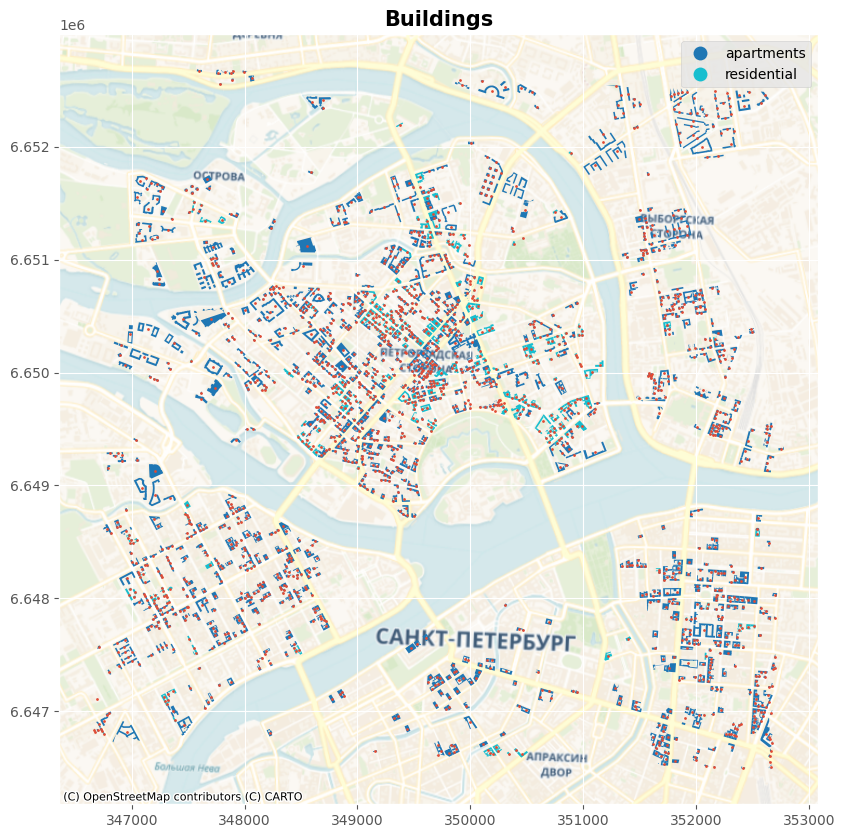

In [187]:
import contextily as cx
from matplotlib import pyplot as plt


with plt.style.context("ggplot"):
  ax = buildings.plot(column='building', figsize=(20,10), legend=True, linewidth=0.4, legend_kwds=dict(loc='upper right', ncol=1))
  ax = buildings['centroid'].plot(ax=ax, markersize=2)
  cx.add_basemap(ax=ax, crs=buildings.crs.to_string(), source=cx.providers.CartoDB.Voyager)
  ax.set_title('Buildings', fontsize=15, fontweight='bold')
  fp = config['dir_osm']+'images/buildings.png'
  plt.savefig(fp)
  logger.info(f'save buildings to {fp}')
  plt.show()

In [87]:
#buildings.explore(column='building', tiles="CartoDB positron")

In [188]:
fp = ''
if 'bbox' in config:
  fp = DIR_OSM + 'spb_bbox.gpkg'
  buildings.drop(columns='centroid').to_file(fp, driver='GPKG', layer='buildings', encoding='utf-8')
  logger.info(f'save buildings to {fp}')
else:
  fp = DIR_OSM + 'spb.gpkg'
  buildings.drop(columns='centroid').to_file(fp, driver='GPKG', layer='buildings', encoding='utf-8')
  logger.info(f'save buildings to {fp}')

INFO:root:save buildings to /content/drive/MyDrive/vkr/kmu/src/osm/spb_bbox.gpkg


In [189]:
from geopandas import read_file


buildings_from_gpkg = read_file(fp, layer='buildings').set_index('id')

if buildings.shape[0] == buildings_from_gpkg.shape[0] and buildings.crs == buildings_from_gpkg.crs:
  logger.info(f'buildings successfully loaded from gpkg')

buildings_from_gpkg.head(2)

INFO:root:buildings successfully loaded from gpkg


building     centroid_x    centroid_y  \
id                                                  
16960662  apartments  346952.030481  6.648785e+06   
17063465  apartments  346792.083845  6.649158e+06   

                                                   geometry  
id                                                           
16960662  POLYGON ((346938.573 6648792.461, 346950.029 6...  
17063465  POLYGON ((346796.010 6649130.969, 346780.855 6...

### POIs

In [191]:
pois_type = config["filters"]["POIs"]

pois = osm.get_data_by_custom_criteria(custom_filter=pois_type, tags_as_columns=["shop", "amenity", "healthcare", "name"]).set_index('id')
logger.info(f'get pois by filter {pois_type}')

INFO:root:get pois by filter {'shop': ['convenience', 'supermarket', 'mall', 'greengrocer'], 'amenity': ['pharmacy', 'school', 'kindergarten', 'clinic'], 'healthcare': ['clinic']}


In [192]:
pois = pois.dropna(subset=["name"])
logger.info(f'drop unnamed pois')

INFO:root:drop unnamed pois


In [195]:
pois.loc[~pois.shop.isin(config["filters"]["POIs"]["shop"]), "shop"] = ""
pois.loc[~pois.amenity.isin(config["filters"]["POIs"]["amenity"]), "amenity"] = ""
pois.loc[~pois.healthcare.isin(config["filters"]["POIs"]["healthcare"]), "healthcare"] = ""

pois["pois"] = pois.shop + pois.amenity + pois.healthcare
pois.loc[pois.pois == "clinicclinic", "pois"] = "clinic"

logger.info(f'add pois type')

INFO:root:add pois type


In [196]:
pois = pois[['pois', 'geometry']].to_crs(config['crs'])
logger.info(f'project pois to {pois.crs.to_string()}')
pois.head(2)

INFO:root:project pois to EPSG:32636


pois                        geometry
id                                                    
332263460  supermarket  POINT (350111.535 6650153.889)
339394777     pharmacy  POINT (349698.538 6649757.709)

In [197]:
pois['geometry'] = pois.centroid
pois['centroid_x'] = pois.geometry.x
pois['centroid_y'] = pois.geometry.y

logger.info(f'replace pois geometry to centroid')

INFO:root:replace pois geometry to centroid


INFO:root:save pois to /content/drive/MyDrive/vkr/kmu/src/osm/images/pois.png


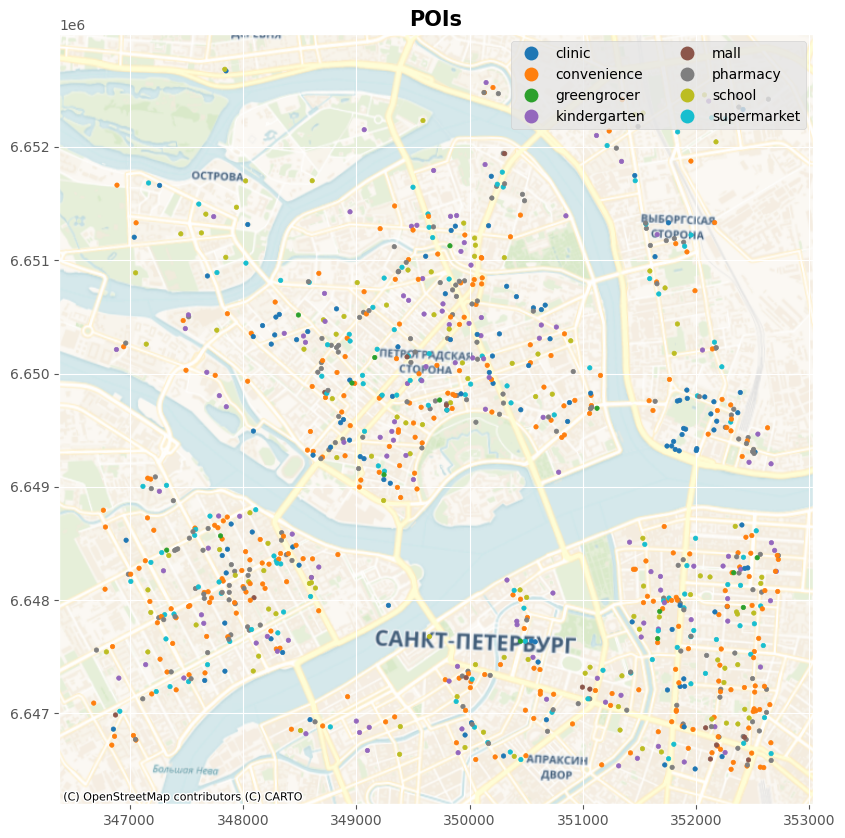

In [198]:
import contextily as cx
from matplotlib import pyplot as plt


with plt.style.context('ggplot'):
  ax = pois.plot(column='pois', figsize=(20,10), legend=True, markersize=10, legend_kwds=dict(loc='upper right', ncol=2))
  cx.add_basemap(ax=ax, crs=pois.crs.to_string(), source=cx.providers.CartoDB.Voyager)
  ax.set_title('POIs', fontsize=15, fontweight='bold')
  fp = config['dir_osm']+'images/pois.png'
  plt.savefig(fp)
  logger.info(f'save pois to {fp}')
  plt.show()

In [96]:
#pois.explore(column='pois', tiles="CartoDB positron")

In [199]:
fp = ''
if 'bbox' in config:
  fp = DIR_OSM + 'spb_bbox.gpkg'
  pois.to_file(fp, driver='GPKG', layer='pois', encoding='utf-8')
  logger.info(f'save pois to {fp}')
else:
  fp = DIR_OSM + 'spb.gpkg'
  pois.to_file(fp, driver='GPKG', layer='pois', encoding='utf-8')
  logger.info(f'save pois to {fp}')

INFO:root:save pois to /content/drive/MyDrive/vkr/kmu/src/osm/spb_bbox.gpkg


In [200]:
from geopandas import read_file


pois_from_gpkg = read_file(fp, layer='pois').set_index('id')

if pois.shape[0] == pois_from_gpkg.shape[0] and pois.crs == pois_from_gpkg.crs:
  logger.info(f'pois successfully loaded from gpkg')

pois_from_gpkg.head(2)

INFO:root:pois successfully loaded from gpkg


pois     centroid_x    centroid_y  \
id                                                    
332263460  supermarket  350111.535453  6.650154e+06   
339394777     pharmacy  349698.538406  6.649758e+06   

                                 geometry  
id                                         
332263460  POINT (350111.535 6650153.889)  
339394777  POINT (349698.538 6649757.709)

### Network

In [302]:
network_type = config['filters']['network_type'][0]
#network_type = config['filters']['network_type'][1]

nodes, edges = osm.get_network(nodes=True, network_type=network_type)

if network_type == 'walking':
  logger.info(f'get {network_type} nodes and edges by exclude filter {osm.conf.network_filters.walking}')
  edges.oneway = edges.oneway.fillna('no')

  indexes = [i for i, flag in edges.oneway.items() if type(flag) != str]
  edges.loc[indexes, 'oneway'] = 'no'

  indexes = [i for i, flag in edges.highway.items() if type(flag) != str]
  edges.loc[indexes, 'highway'] = edges.highway.value_counts().index[0] # 'footway'


elif network_type == 'driving':
  logger.info(f'get {network_type} nodes and edges by exclude filter {osm.conf.network_filters.driving}')
  edges.oneway = edges.oneway.fillna('yes')

  indexes = [i for i, flag in edges.oneway.items() if type(flag) != str]
  edges.loc[indexes, 'oneway'] = 'yes'

  indexes = [i for i, flag in edges.highway.items() if type(flag) != str]
  edges.loc[indexes, 'highway'] = edges.highway.value_counts().index[0] # 'service'

INFO:root:get walking nodes and edges by exclude filter {'area': ['yes'], 'highway': ['cycleway', 'motor', 'proposed', 'construction', 'abandoned', 'platform', 'raceway', 'motorway', 'motorway_link'], 'foot': ['no'], 'service': ['private']}


In [303]:
graph = osm.to_graph(nodes, edges, graph_type='networkx')
logger.info(f'convert {network_type} nodes and edges to networkx graph')

INFO:root:convert walking nodes and edges to networkx graph


In [305]:
from osmnx import simplify_graph, graph_to_gdfs


graph_s = simplify_graph(graph)
logger.info(f'simplify {network_type} graph')

nodes_s = graph_to_gdfs(graph_s, edges=False)
edges_s = graph_to_gdfs(graph_s, nodes=False)
logger.info(f'get {network_type} nodes and edges of simplified graph')

if network_type == 'walking':
  edges_s.oneway = edges_s.oneway.fillna('no')

  indexes = [i for i, flag in edges_s.oneway.items() if type(flag)!= str]
  edges_s.loc[indexes, 'oneway'] = 'no'

  indexes = [i for i, flag in edges_s.highway.items() if type(flag) != str]
  edges_s.loc[indexes, 'highway'] = edges_s.highway.value_counts().index[0] # 'footway'

elif network_type == 'driving':
  edges_s.oneway = edges_s.oneway.fillna('yes')
  indexes = [i for i, flag in edges_s.oneway.items() if type(flag) != str]
  edges_s.loc[indexes, 'oneway'] = 'yes'

  indexes = [i for i, flag in edges_s.highway.items() if type(flag) != str]
  edges_s.loc[indexes, 'highway'] = edges_s.highway.value_counts().index[0] # 'service'

INFO:root:simplify walking graph
INFO:root:get walking nodes and edges of simplified graph


In [306]:
nodes_s = nodes_s.rename(columns={'osmid':'id'}).set_index('id')[['geometry']].to_crs(config['crs'])
nodes_s['x'] = nodes_s.geometry.x
nodes_s['y'] = nodes_s.geometry.y
logger.info(f'project {network_type} nodes to {nodes_s.crs.to_string()}')
nodes_s.head(2)

INFO:root:project walking nodes to EPSG:32636


geometry              x             y
id                                                                      
10240355599  POINT (350768.978 6647816.641)  350768.977867  6.647817e+06
1591433310   POINT (350772.207 6647830.545)  350772.206656  6.647831e+06

In [307]:
edges_s = edges_s.reset_index()[['u', 'v', 'length', 'oneway', 'highway', 'geometry']].to_crs(config['crs'])
logger.info(f'project {network_type} edges to {nodes_s.crs.to_string()}')
edges_s.head(2)

INFO:root:project walking edges to EPSG:32636


u           v  length oneway       highway  \
0  10240355599  1591433310  14.247     no  unclassified   
1   1591433310  9296451194  24.230     no  unclassified   

                                            geometry  
0  LINESTRING (350768.978 6647816.641, 350769.630...  
1  LINESTRING (350772.207 6647830.545, 350777.960...

In [308]:
nodes = nodes.set_index('id')[['geometry']].to_crs(config['crs'])
nodes['x'] = nodes.geometry.x
nodes['y'] = nodes.geometry.y
logger.info(f'project {network_type} nodes of origin graph to {nodes.crs.to_string()}')

edges = edges.reset_index()[['u', 'v', 'length', 'oneway', 'highway', 'geometry']].to_crs(config['crs'])
logger.info(f'project {network_type} edges of origin graph to {nodes.crs.to_string()}')

INFO:root:project walking nodes of origin graph to EPSG:32636
INFO:root:project walking edges of origin graph to EPSG:32636


INFO:root:save walking graph to /content/drive/MyDrive/vkr/kmu/src/osm/images/walking_graph_compare.png


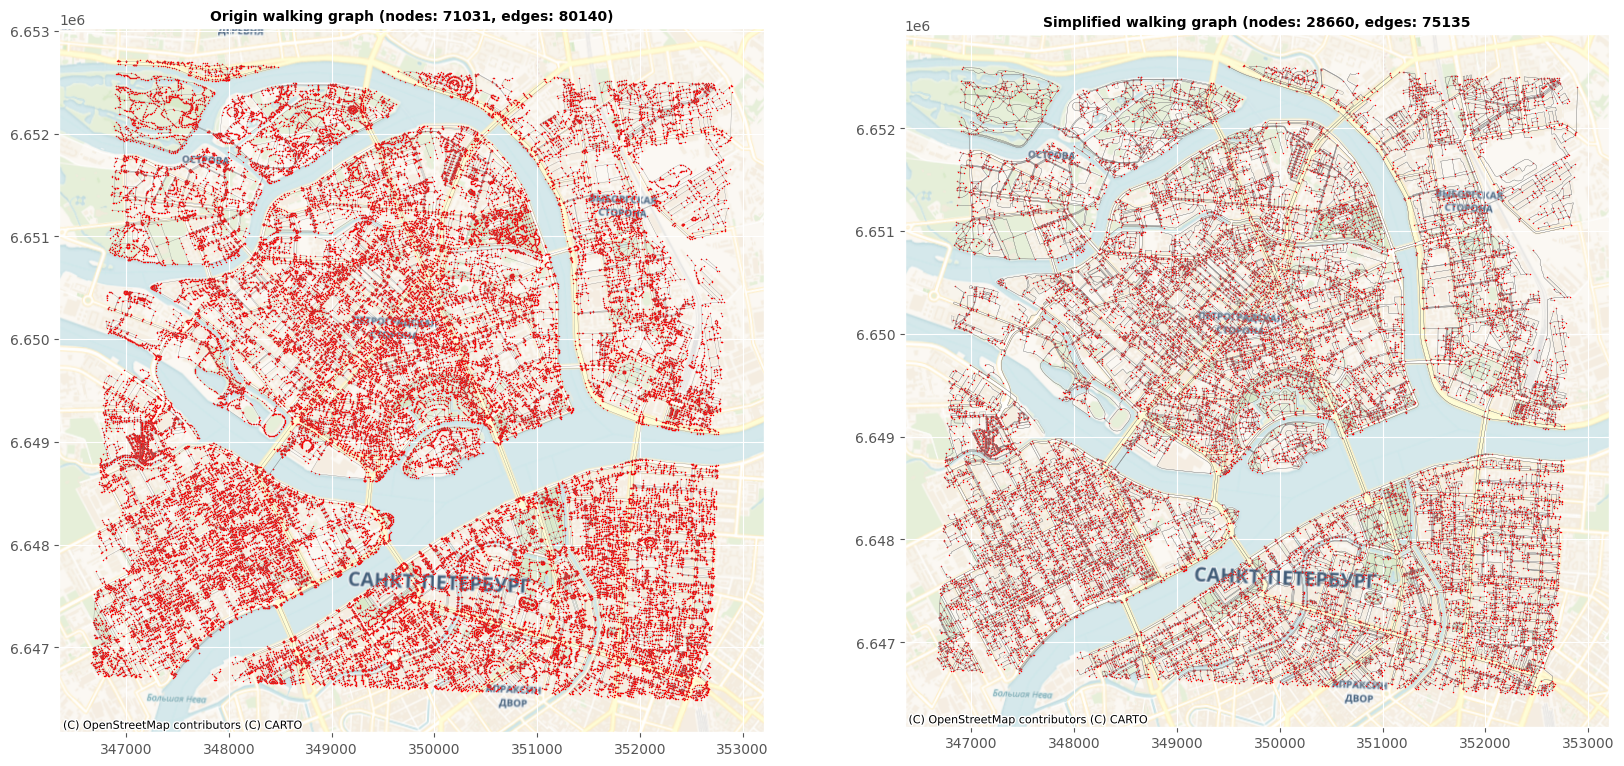

In [309]:
import contextily as cx
from matplotlib import pyplot as plt


with plt.style.context('ggplot'):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

  # plot edges and nodes of origin graph
  ax1 = edges.plot(ax=axes[0], color="gray", linewidth=0.2)
  ax1 = nodes.plot(ax=ax1, color="red", markersize=0.3)
  #plt.setp(ax1, xlim=(349000, 349500), ylim=(6650000, 6650500))
  cx.add_basemap(ax=ax1, crs=nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)

  # plot edges and nodes of simplified graph
  ax2 = edges_s.plot(ax=axes[1], color="gray", linewidth=0.2)
  ax2 = nodes_s.plot(ax=ax2, color="red", markersize=0.3)
  #plt.setp(ax2, xlim=(349000, 349500), ylim=(6650000, 6650500))
  cx.add_basemap(ax=ax2, crs=nodes_s.crs.to_string(), source=cx.providers.CartoDB.Voyager)

  # add titles to maps
  ax1.set_title(f'Origin {network_type} graph (nodes: {len(nodes)}, edges: {len(edges)})', fontsize=10, fontweight='bold')
  ax2.set_title(f'Simplified {network_type} graph (nodes: {len(nodes_s)}, edges: {len(edges_s)}', fontsize=10, fontweight='bold')

  fp = config['dir_osm']+f'images/{network_type}_graph_compare.png'
  plt.savefig(fp)
  logger.info(f'save {network_type} graph to {fp}')
  plt.show()

In [310]:
fp = ''
if 'bbox' in config:
  fp = DIR_OSM + 'spb_bbox.gpkg'
  nodes_s.to_file(fp, driver='GPKG', layer=f'{network_type}_nodes', encoding='utf-8')
  edges_s.to_file(fp, driver='GPKG', layer=f'{network_type}_edges', encoding='utf-8')
  logger.info(f'save {network_type} nodes and edges of simplified graph to {fp}')
else:
  fp = DIR_OSM + 'spb.gpkg'
  nodes_s.to_file(fp, driver='GPKG', layer=f'{network_type}_nodes', encoding='utf-8')
  edges_s.to_file(fp, driver='GPKG', layer=f'{network_type}_edges', encoding='utf-8')
  logger.info(f'save {network_type} nodes and edges of simplified graph to {fp}')

INFO:root:save walking nodes and edges of simplified graph to /content/drive/MyDrive/vkr/kmu/src/osm/spb_bbox.gpkg


In [311]:
from geopandas import read_file


nodes_from_gpkg = read_file(fp, layer=f'{network_type}_nodes').set_index('id')
edges_from_gpkg = read_file(fp, layer=f'{network_type}_edges')

if nodes_s.shape[0] == nodes_from_gpkg.shape[0] and nodes_s.crs == nodes_from_gpkg.crs:
  logger.info(f'{network_type} nodes and edges of simplified graph successfully loaded from gpkg')

INFO:root:walking nodes and edges of simplified graph successfully loaded from gpkg


In [312]:
nodes_from_gpkg.head(2)

x             y                        geometry
id                                                                      
10240355599  350768.977867  6.647817e+06  POINT (350768.978 6647816.641)
1591433310   350772.206656  6.647831e+06  POINT (350772.207 6647830.545)

In [313]:
edges_from_gpkg.head(2)

u           v  length oneway       highway  \
0  10240355599  1591433310  14.247     no  unclassified   
1   1591433310  9296451194  24.230     no  unclassified   

                                            geometry  
0  LINESTRING (350768.978 6647816.641, 350769.630...  
1  LINESTRING (350772.207 6647830.545, 350777.960...

## Заметки

In [ ]:
from osmnx import projection, simplification


graph_s_proj = projection.project_graph(graph_s, to_crs=config['crs'])

# Simplify to get real intersections only
# (consolidate nodes within a distance from eachother)
walking_g_prj_simplified = simplification.consolidate_intersections(
    # Graph to simplify
    graph_s_proj,
    # buffer around each node (project the graph beforehand)
    tolerance=5,
    # Get result as graph (False to get nodes only as gdf)
    rebuild_graph=True,
    # no dead ends
    dead_ends=False,
    # Reconnect (False to get intersections only)
    reconnect_edges=True
)